In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from alpha_vantage.timeseries import TimeSeries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from ta.momentum import RSIIndicator
from ta.trend import MACD
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")


In [12]:
def fetch_data(symbol, api_key=API_KEY):
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, _ = ts.get_daily(symbol=symbol, outputsize='full')
    data = data.sort_index()
    data = data.rename(columns={
        '1. open': 'open',
        '2. high': 'high',
        '3. low': 'low',
        '4. close': 'close',
        '5. volume': 'volume'
    })
    return data


In [13]:
# Apply indicators per ticker
def add_features(df):
    df['return'] = df['close'].pct_change()
    df['rsi'] = RSIIndicator(df['close'], window=14).rsi()
    macd = MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['target'] = np.where(df['return'].shift(-1) > 0, 1, 0)
    df.dropna(inplace=True)
    return df


In [14]:
# Train Random Forest model and calculate performance
def train_evaluate(df):
    features = ['rsi', 'macd', 'macd_signal']
    X = df[features]
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    df = df.iloc[-len(y_pred):].copy()
    df['pred'] = y_pred
    df['strategy'] = np.where(df['pred'] == 1, df['return'], 0)
    
    sharpe = np.sqrt(252) * df['strategy'].mean() / df['strategy'].std()
    cumulative = (1 + df['strategy']).cumprod().iloc[-1]
    return sharpe, cumulative, df['strategy']


In [15]:
# Suppose we already have strategy_returns = { 'AAPL': series1, 'MSFT': series2, ... }

from scipy.optimize import minimize

def optimize_portfolio(returns_dict):
    returns_df = pd.DataFrame(returns_dict)
    weights = np.ones(len(returns_df.columns)) / len(returns_df.columns)

    def neg_sharpe(w):
        port_return = (returns_df * w).sum(axis=1)
        return -np.sqrt(252) * port_return.mean() / port_return.std()

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * len(weights)

    result = minimize(neg_sharpe, weights, bounds=bounds, constraints=constraints)
    return result.x, -result.fun


In [16]:
example_tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'JPM', 'BA']

print("🔢 Example Tickers:")
for i, ticker in enumerate(example_tickers):
    print(f"{i+1}. {ticker}")

chosen_indices = input("Please choose 5 ticker indices (comma-separated, e.g. 1,3,5,7,9): ")
chosen_tickers = [example_tickers[int(i)-1] for i in chosen_indices.split(',')]

print(f"\n✅ You selected: {chosen_tickers}")


🔢 Example Tickers:
1. AAPL
2. MSFT
3. GOOG
4. AMZN
5. META
6. TSLA
7. NFLX
8. NVDA
9. JPM
10. BA



✅ You selected: ['GOOG', 'AMZN', 'META', 'JPM', 'BA']


In [17]:
strategy_returns = {}
sharpe_scores = {}
cumulative_returns = {}

for ticker in chosen_tickers:
    print(f"\n📥 Processing {ticker}...")
    
    try:
        data = fetch_data(ticker)
        data = add_features(data)

        sharpe, cumulative, strat_series = train_evaluate(data)
        
        strategy_returns[ticker] = strat_series
        sharpe_scores[ticker] = sharpe
        cumulative_returns[ticker] = cumulative
        # Buy & Hold return series (baseline strategy)
        buyhold_returns = data['return'].loc[strat_series.index]  # align with strategy period
        strategy_returns[f"{ticker}_buyhold"] = buyhold_returns
        # RSI signal strategy
        data['rsi_signal'] = np.where(data['rsi'] < 30, 1, 0)
        data['rsi_signal'] = np.where(data['rsi'] > 70, -1, data['rsi_signal'])

        # RSI strategy returns
        rsi_returns = data['rsi_signal'].shift(1) * data['return']
        rsi_returns = rsi_returns.loc[strat_series.index]  # align dates

        strategy_returns[f"{ticker}_rsi"] = rsi_returns



        print(f"📊 {ticker} - Sharpe: {sharpe:.2f}, Cumulative Return: {cumulative:.2%}")
    
    except Exception as e:
        print(f"❌ Error processing {ticker}: {e}")



📥 Processing GOOG...
❌ Error processing GOOG: We have detected your API key as BKVEJWBZ2HWPABP0 and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.

📥 Processing AMZN...
❌ Error processing AMZN: We have detected your API key as BKVEJWBZ2HWPABP0 and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.

📥 Processing META...
❌ Error processing META: We have detected your API key as BKVEJWBZ2HWPABP0 and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.

📥 Processing JPM...
❌ Error processing JPM: We have detected your API key as BKVEJWBZ2HWPABP0 and our standard API rate limit is 25 requests per day. Please

In [ ]:
# Ask user for weight between Sharpe and Return
try:
    alpha = float(input("Enter the weight for Sharpe Ratio (between 0 and 1): "))
    if not 0 <= alpha <= 1:
        raise ValueError
except:
    print("Invalid input. Using default alpha = 0.5")
    alpha = 0.5

print(f"⚖️ Optimization will use α = {alpha:.2f} → {alpha:.0%} Sharpe, {(1-alpha):.0%} Return")


In [ ]:
from scipy.optimize import minimize
import numpy as np

def annual_return(returns):
    return (1 + returns).prod()**(252 / len(returns)) - 1

def sharpe_ratio(returns, risk_free_rate=0.0):
    excess = returns - risk_free_rate
    return np.sqrt(252) * excess.mean() / excess.std()

def combined_objective(weights, returns_matrix, alpha):
    portfolio_returns = returns_matrix.dot(weights)
    sharpe = sharpe_ratio(portfolio_returns)
    cagr = annual_return(portfolio_returns)
    return - (alpha * sharpe + (1 - alpha) * cagr)  # Negative to minimize

def optimize_combined_strategy(returns_matrix, alpha):
    n = returns_matrix.shape[1]
    init_guess = np.ones(n) / n
    bounds = [(0.0, 1.0)] * n
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    result = minimize(combined_objective, init_guess,
                      args=(returns_matrix, alpha),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    return result.x, -result.fun  # weights, score


In [ ]:
# Separate by strategy type
rf_strategies = {k: v for k, v in strategy_returns.items() if 'rf' in k.lower()}
rsi_strategies = {k: v for k, v in strategy_returns.items() if 'rsi' in k.lower()}
buyhold_strategies = {k: v for k, v in strategy_returns.items() if 'buyhold' in k.lower()}

strategy_sets = {
    'Random Forest': rf_strategies,
    'RSI': rsi_strategies,
    'Buy & Hold': buyhold_strategies
}

optimized_weights = {}
cumulative_returns = {}

for name, strat_dict in strategy_sets.items():
    returns_df = pd.concat(strat_dict.values(), axis=1).fillna(0)
    weights, _ = optimize_combined_strategy(returns_df, alpha)
    portfolio_returns = returns_df.dot(weights)
    cumulative_returns[name] = (1 + portfolio_returns).cumprod()
    optimized_weights[name] = weights
    print(f"✅ Optimized {name} Portfolio — Final Value: {cumulative_returns[name].iloc[-1]:.4f}")


ValueError: No objects to concatenate

In [ ]:

print("\n💼 Optimized Portfolio Weights:")
for ticker, weight in zip(strategy_returns.keys(), weights_rf):
    print(f"{ticker}: {weight:.2%}")

print(f"\n🚀 Optimized Portfolio Sharpe Ratio: {sharpe_rf:.2f}")


print("\n💼 Optimized Portfolio Weights:")
for ticker, weight in zip(strategy_returns.keys(), weights_rsi):
    print(f"{ticker}: {weight:.2%}")

print(f"\n🚀 Optimized Portfolio Sharpe Ratio: {sharpe_rsi:.2f}")


print("\n💼 Optimized Portfolio Weights:")
for ticker, weight in zip(strategy_returns.keys(), weights_bh):
    print(f"{ticker}: {weight:.2%}")

print(f"\n🚀 Optimized Portfolio Sharpe Ratio: {sharpe_bh:.2f}")





💼 Optimized Portfolio Weights:
GOOG: 0.00%
GOOG_buyhold: 0.00%
GOOG_rsi: 83.09%
AMZN: 16.91%
AMZN_buyhold: 0.00%

🚀 Optimized Portfolio Sharpe Ratio: 0.92

💼 Optimized Portfolio Weights:
GOOG: 54.03%
GOOG_buyhold: 15.14%
GOOG_rsi: 0.00%
AMZN: 30.82%
AMZN_buyhold: 0.00%

🚀 Optimized Portfolio Sharpe Ratio: 1.25

💼 Optimized Portfolio Weights:
GOOG: 0.00%
GOOG_buyhold: 0.00%
GOOG_rsi: 66.77%
AMZN: 33.23%
AMZN_buyhold: 0.00%

🚀 Optimized Portfolio Sharpe Ratio: 1.67


In [ ]:
import joblib

weights_path = "/workspaces/backtesting/investment-portfolio-project/models/optimized_weights.pkl"
joblib.dump(optimized_weights, weights_path)
print(f"💾 Optimized weights saved to: {weights_path}")


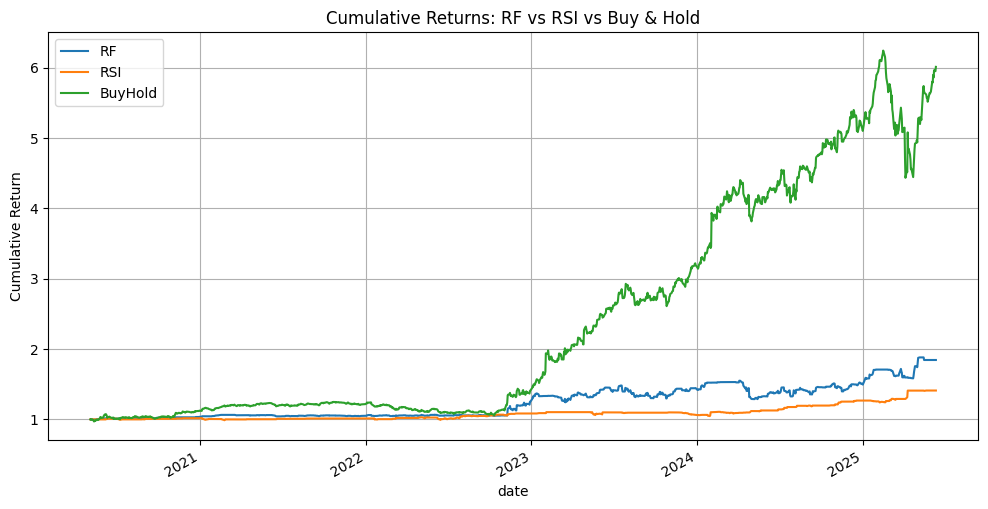

In [ ]:
cumulative_returns = {}
for label, (weights, strategy_dict) in portfolios.items():
    matrix = pd.concat(strategy_dict.values(), axis=1).fillna(0)
    weighted_returns = matrix.dot(weights)
    cumulative_returns[label] = (1 + weighted_returns).cumprod()
pd.DataFrame(cumulative_returns).plot(figsize=(12,6), title="Cumulative Returns: RF vs RSI vs Buy & Hold")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()
